# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [9]:
# The new version of dataset is only available in the tfds-nightly package.
%pip --no-cache-dir install tfds-nightly --user
# DON'T MISS TO RESTART THE KERNEL

     |████████████████████████████████| 3.3MB 2.1MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import TensorFlow 
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# TODO: Make all other necessary imports.
print('TensorFlow version:',tf.__version__)
print('tf.keras version:',tf.keras.__version__)
print('Is there a GPU Available:',tf.test.is_gpu_available())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version: 2.0.0
tf.keras version: 2.2.4-tf
Is there a GPU Available: True
Num GPUs Available:  1


## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [3]:
# Download data to default local directory "~/tensorflow_datasets"
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums=True --datasets=oxford_flowers102

# TODO: Load the dataset with TensorFlow Datasets. Hint: use tfds.load()

dataset, dataset_info = tfds.load("oxford_flowers102", as_supervised=True, with_info=True)

# TODO: Create a training set, a validation set and a test set.

#splits = tfds.Split.ALL.subsplit([60,20, 20])
train_set=dataset['train']
validation_set=dataset['validation']
test_set=dataset['test']



I0609 17:45:32.259497 139969100068608 download_and_prepare.py:201] Running download_and_prepare for dataset(s):
oxford_flowers102
I0609 17:45:32.315331 139969100068608 dataset_info.py:427] Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: oxford_flowers102/2.1.1
I0609 17:45:32.530989 139969100068608 dataset_info.py:358] Load dataset info from /tmp/tmpv8vfm2qvtfds
I0609 17:45:32.542437 139969100068608 download_and_prepare.py:139] download_and_prepare for dataset oxford_flowers102/2.1.1...
I0609 17:45:32.543004 139969100068608 dataset_builder.py:345] Generating dataset oxford_flowers102 (/root/tensorflow_datasets/oxford_flowers102/2.1.1)
Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]I0609 17:45:32.649714 139969100068608 download_manager.py:477] Downloading https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz into /root/tensorflow_datasets/downloads/robots.ox.ac.uk_vgg_flowers_1

## Explore the Dataset

In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    version=2.1.1,
    description='The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1020 images each).
The test set consists of the remaining 6149 images (minimum 20 per class).',
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
    }),
    total_num_examples=8

In [5]:

# TODO: Get the number of examples in each set from the dataset info.
print("There are {} images in the training set".format(dataset_info.splits['train'].num_examples))
print("There are {} images in the validation set".format(dataset_info.splits['validation'].num_examples))
print('There are {} images in the test set'.format(dataset_info.splits['test'].num_examples))

# TODO: Get the number of classes in the dataset from the dataset info.
print('There are {} classes in the oxford_flowers102 dataset'.format(dataset_info.features['label'].num_classes))

There are 1020 images in the training set
There are 1020 images in the validation set
There are 6149 images in the test set
There are 102 classes in the oxford_flowers102 dataset


In [40]:
""" class_names = ["pink primrose", "hard-leaved pocket orchid", "canterbury bells",
    "sweet pea", "english marigold", "tiger lily", "moon orchid",
    "bird of paradise", "monkshood", "globe thistle", "snapdragon",
    "colt's foot", "king protea", "spear thistle", "yellow iris",
    "globe-flower", "purple coneflower", "peruvian lily", "balloon flower",
    "giant white arum lily", "fire lily", "pincushion flower", "fritillary",
    "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers",
    "stemless gentian", "artichoke", "sweet william", "carnation",
    "garden phlox", "love in the mist", "mexican aster", "alpine sea holly",
    "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip",
    "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia",
    "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy",
    "common dandelion", "petunia", "wild pansy", "primula", "sunflower",
    "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia",
    "pink-yellow dahlia?", "cautleya spicata", "japanese anemone",
    "black-eyed susan", "silverbush", "californian poppy", "osteospermum",
    "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania",
    "azalea", "water lily", "rose", "thorn apple", "morning glory",
    "passion flower", "lotus", "toad lily", "anthurium", "frangipani",
    "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow",
    "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum",
    "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow",
    "mexican petunia", "bromelia", "blanket flower", "trumpet creeper",
    "blackberry lily"] """ 

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [6]:
import json
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

In [7]:
class_names1 = dict()
for key in class_names:
    class_names1[str(int(key)-1)] = class_names[key]

In [8]:
print(class_names1)

{'20': 'fire lily', '2': 'canterbury bells', '44': 'bolero deep blue', '0': 'pink primrose', '33': 'mexican aster', '26': 'prince of wales feathers', '6': 'moon orchid', '15': 'globe-flower', '24': 'grape hyacinth', '25': 'corn poppy', '78': 'toad lily', '38': 'siam tulip', '23': 'red ginger', '66': 'spring crocus', '34': 'alpine sea holly', '31': 'garden phlox', '9': 'globe thistle', '5': 'tiger lily', '92': 'ball moss', '32': 'love in the mist', '8': 'monkshood', '101': 'blackberry lily', '13': 'spear thistle', '18': 'balloon flower', '99': 'blanket flower', '12': 'king protea', '48': 'oxeye daisy', '14': 'yellow iris', '60': 'cautleya spicata', '30': 'carnation', '63': 'silverbush', '67': 'bearded iris', '62': 'black-eyed susan', '68': 'windflower', '61': 'japanese anemone', '19': 'giant white arum lily', '37': 'great masterwort', '3': 'sweet pea', '85': 'tree mallow', '100': 'trumpet creeper', '41': 'daffodil', '21': 'pincushion flower', '1': 'hard-leaved pocket orchid', '53': 'sun

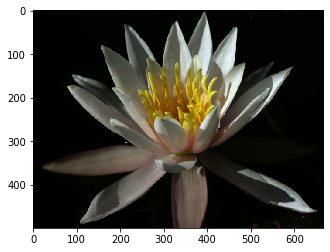

Image 1 label is : 72, Title is: water lily, and shape is : (500, 667, 3)


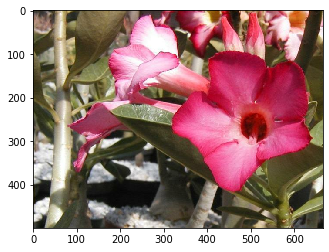

Image 2 label is : 84, Title is: desert-rose, and shape is : (500, 666, 3)


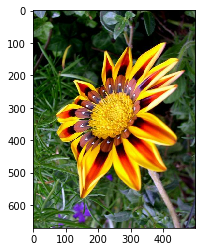

Image 3 label is : 70, Title is: gazania, and shape is : (670, 500, 3)


In [9]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
i=0
for image,label in train_set.take(3):
    image = image.numpy()
    label = label.numpy()
    plt.imshow(image)
    plt.show()
    i+=1
    print('Image {0} label is : {1}, Title is: {2}, and shape is : {3}'.format(i,label,class_names1[str(label)],image.shape))

(500, 667, 3)


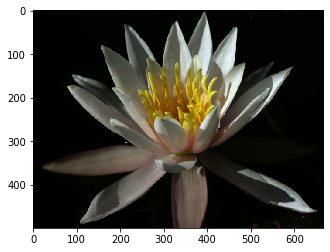

The label of this image is: 72
The class name of this image is: water lily


In [10]:
# TODO: Plot 1 image from the training set. 
# Set the title of the plot to the corresponding image label. 
for image, label in train_set.take(1):
    image = image.numpy()
    label = label.numpy()
    print(image.shape)
plt.imshow(image)
plt.show()

print('The label of this image is:', label)
print('The class name of this image is:', class_names1[str(label)])


72


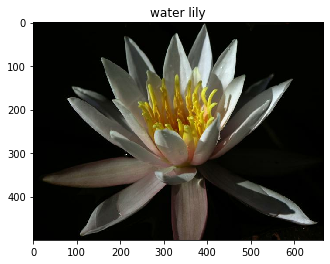

In [69]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 

for image,label in train_set.take(1):
    image = image.numpy()
    label = label.numpy()
    plt.imshow(image)
    plt.title(class_names1[str(label)])
    print(label)

## Create Pipeline

In [11]:
# TODO: Create a pipeline for each set.

batch_size = 32
image_size = 224
def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label

#data spliting
training_batches = train_set.shuffle(23262*60//4).map(format_image).batch(batch_size).prefetch(1)
validation_batches = validation_set.map(format_image).batch(batch_size).prefetch(1)
testing_batches = test_set.map(format_image).batch(batch_size).prefetch(1)


# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [20]:
# Load the MobileNet pre-trained network from TensorFlow Hub.
# TODO: Build network.

tf.keras.backend.clear_session() 
model = tf.keras.Sequential([hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4", input_shape=(224, 224, 3), trainable=False),
           tf.keras.layers.Flatten(input_shape =(224, 224, 3)),
           tf.keras.layers.Dense(800, activation = 'relu'),
           tf.keras.layers.Dropout(0.2),
           tf.keras.layers.Dense(400, activation = 'relu'),
           tf.keras.layers.Dropout(0.2),
           tf.keras.layers.Dense(102,activation = 'softmax')
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              1343049   
_________________________________________________________________
flatten (Flatten)            (None, 1001)              0         
_________________________________________________________________
dense (Dense)                (None, 800)               801600    
_________________________________________________________________
dropout (Dropout)            (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               320400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 102)               4

In [21]:
# Train your Network
 
# Define the necesserily parameters:
model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Stop training when there is no improvement in the validation loss for 5 consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Save the Model with the lowest validation loss
save_best = tf.keras.callbacks.ModelCheckpoint('./best_model.h5',
                                               monitor='val_loss',
                                               save_best_only=True,
                                               save_weights_only=False)


#from workspace_utils import active_session
#with active_session():
history = model.fit(training_batches,
                    epochs = 20,
                    validation_data=validation_batches,
                    callbacks=[early_stopping, save_best])

Epoch 1/20
32/32 [==============================] - 10s 299ms/step - loss: 4.9212 - accuracy: 0.0402 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 6s 199ms/step - loss: 3.4684 - accuracy: 0.2108 - val_loss: 2.7362 - val_accuracy: 0.3882
Epoch 3/20
32/32 [==============================] - 6s 199ms/step - loss: 2.3466 - accuracy: 0.3931 - val_loss: 2.0119 - val_accuracy: 0.4951
Epoch 4/20
32/32 [==============================] - 6s 199ms/step - loss: 1.6000 - accuracy: 0.5647 - val_loss: 1.7124 - val_accuracy: 0.5627
Epoch 5/20
32/32 [==============================] - 6s 198ms/step - loss: 1.2527 - accuracy: 0.6431 - val_loss: 1.4145 - val_accuracy: 0.6147
Epoch 6/20
32/32 [==============================] - 6s 199ms/step - loss: 0.9039 - accuracy: 0.7471 - val_loss: 1.3466 - val_accuracy: 0.6588
Epoch 7/20
32/32 [==============================] - 6s 198ms/step - loss: 0.6513 - accuracy: 0.7971 - val_loss: 1.2033 - val_accuracy: 0.69

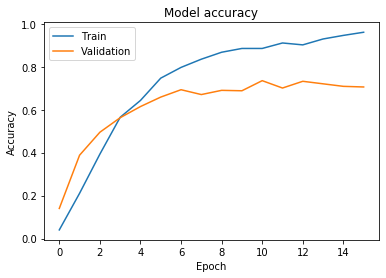

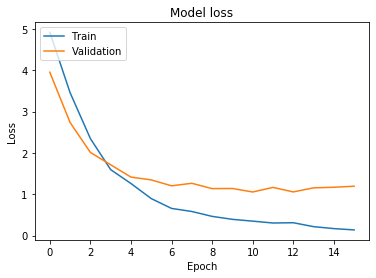

In [22]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.

# Potting Accuracy values :
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [23]:
# TODO: Print the loss and accuracy values achieved on the entire test set.

loss, accuracy,  = model.evaluate(testing_batches)
print("Accuracy :",accuracy, "\nLoss :",loss)

193/193 [==============================] - 18s 92ms/step - loss: 1.3479 - accuracy: 0.6858
Accuracy : 0.6858026 
Loss : 1.3478996489640962


In [35]:
# transfer learning technique:

# extract the pretrained model without the output layer:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))
# pause/freeze the parmaters of pretrained model:
feature_extractor.trainable = False
# build the model by insert the pretrained model + your classifier layers:
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(102, activation = 'softmax')
])

#define the necesserily parameters:
model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
# Stop training when there is no improvement in the validation loss for 5 consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Save the Model with the lowest validation loss
save_best = tf.keras.callbacks.ModelCheckpoint('./best_model.h5',
                                               monitor='val_loss',
                                               save_best_only=True)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_3 (Dense)              (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [36]:
history = model.fit(training_batches,
                    epochs = 20,
                    validation_data=validation_batches,
                    callbacks=[early_stopping, save_best])

Epoch 1/20
32/32 [==============================] - 12s 389ms/step - loss: 4.2659 - accuracy: 0.1196 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 7s 213ms/step - loss: 2.0670 - accuracy: 0.6765 - val_loss: 2.0047 - val_accuracy: 0.6422
Epoch 3/20
32/32 [==============================] - 7s 210ms/step - loss: 1.0907 - accuracy: 0.9069 - val_loss: 1.5300 - val_accuracy: 0.7441
Epoch 4/20
32/32 [==============================] - 7s 209ms/step - loss: 0.6586 - accuracy: 0.9588 - val_loss: 1.2945 - val_accuracy: 0.7657
Epoch 5/20
32/32 [==============================] - 7s 216ms/step - loss: 0.4404 - accuracy: 0.9833 - val_loss: 1.1512 - val_accuracy: 0.7922
Epoch 6/20
32/32 [==============================] - 7s 213ms/step - loss: 0.3090 - accuracy: 0.9951 - val_loss: 1.0716 - val_accuracy: 0.7922
Epoch 7/20
32/32 [==============================] - 7s 214ms/step - loss: 0.2313 - accuracy: 0.9990 - val_loss: 1.0014 - val_accuracy: 0.80

In [37]:
loss, accuracy,  = model.evaluate(testing_batches)
print("Accuracy :",accuracy, "\nLoss :",loss)

193/193 [==============================] - 19s 99ms/step - loss: 0.8957 - accuracy: 0.7835
Accuracy : 0.78354204 
Loss : 0.8957147002220154


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [38]:
# TODO: Save your trained model as a Keras model.

save_best = tf.keras.callbacks.ModelCheckpoint('./best_model.h5',
                                               monitor='val_loss',
                                               save_best_only=True)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_3 (Dense)              (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


## Load the Keras Model

Load the Keras model you saved above.

In [39]:
# TODO: Load the Keras model

loaded_model = tf.keras.models.load_model('./best_model.h5',custom_objects={'KerasLayer':hub.KerasLayer})
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_3 (Dense)              (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [40]:
# TODO: Create the process_image function

def process_image(numpy_image):
    image = tf.image.convert_image_dtype(numpy_image, dtype=tf.int16, saturate=False)
    image = tf.image.resize(numpy_image, (image_size, image_size)).numpy()
    image /= 255
    return image

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

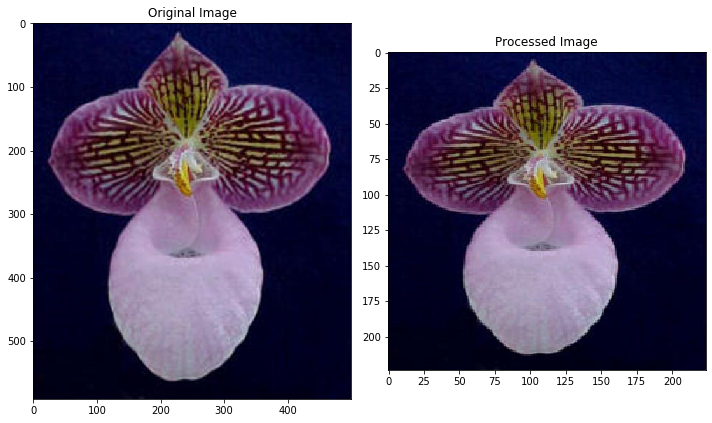

In [41]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [42]:
# TODO: Create the predict function

def predict(image_path, model, top_k):
    
    image = Image.open(image_path)
    test_image = np.asarray(image)
    processed_test_image = process_image(test_image)

    print(processed_test_image.shape, np.expand_dims(processed_test_image,axis=0).shape)
    prob_preds = model.predict(np.expand_dims(processed_test_image,axis=0))
    prob_preds = prob_preds[0].tolist()

    values, indices= tf.math.top_k(prob_preds, k=top_k)
    probs=values.numpy().tolist()
    classes=indices.numpy().tolist()
    return probs, classes
    

In [43]:
probs, classes = predict('./test_images/hard-leaved_pocket_orchid.jpg',loaded_model, 5)

class_names = [class_names1[str(i)] for i in classes]
print('\n\nprediction probabilities :\n',probs,'\n')
print('prediction classes:\n',classes,'\n')
print('prediction labels:\n',class_names,'\n')

(224, 224, 3) (1, 224, 224, 3)


prediction probabilities :
 [0.9965311884880066, 0.0006498244474641979, 0.0005579431308433414, 0.00048044638242572546, 0.0003877800772897899] 

prediction classes:
 [1, 67, 5, 79, 6] 

prediction labels:
 ['hard-leaved pocket orchid', 'bearded iris', 'tiger lily', 'anthurium', 'moon orchid'] 



# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

In [44]:
import seaborn as sns
# TODO: Plot the input image along with the top 5 classes
image1_path = './test_images/cautleya_spicata.jpg'
image2_path = './test_images/hard-leaved_pocket_orchid.jpg'
image3_path = './test_images/wild_pansy.jpg'
image4_path = './test_images/orange_dahlia.jpg'


def plot_image(image_path, index):
    
    #process image
    image = Image.open(image_path)
    test_image = np.asarray(image)
    processed_test_image = process_image(test_image)
    
    #predict, print 5 highest probabilities, classes, and labels
    probs, classes = predict(image_path, loaded_model, 5)
    class_names = [class_names1[str(i)] for i in classes]
    print('prediction probabilities :\n',probs,'\n')
    print('prediction classes:\n',classes,'\n')
    print('prediction labels:\n',class_names,'\n')
    
    #plot image
    ax = plt.subplot(2, 2, index*2 + 1)
    title = image_path.rsplit("/",1)[-1]
    plt.title(title)
    plt.imshow(processed_test_image)
    plt.show()
  
    #plot bar chart
    ax = plt.subplot(2, 2, index*2 + 2)
    ax.yaxis.tick_right()
    sns.barplot(x=probs, y=class_names, color=sns.color_palette()[0])


(224, 224, 3) (1, 224, 224, 3)
prediction probabilities :
 [0.8569657206535339, 0.05015373229980469, 0.03573346883058548, 0.008359712548553944, 0.008259952068328857] 

prediction classes:
 [60, 45, 23, 38, 10] 

prediction labels:
 ['cautleya spicata', 'wallflower', 'red ginger', 'siam tulip', 'snapdragon'] 



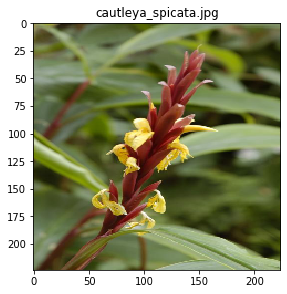

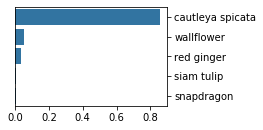

In [45]:
# image 1
plt.figure(figsize = (10,10))
plot_image(image1_path,0)
plt.show()

(224, 224, 3) (1, 224, 224, 3)
prediction probabilities :
 [0.9965311884880066, 0.0006498244474641979, 0.0005579431308433414, 0.00048044638242572546, 0.0003877800772897899] 

prediction classes:
 [1, 67, 5, 79, 6] 

prediction labels:
 ['hard-leaved pocket orchid', 'bearded iris', 'tiger lily', 'anthurium', 'moon orchid'] 



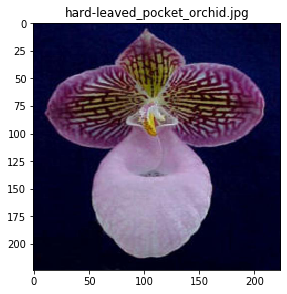

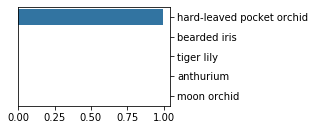

In [46]:
# image 2
plt.figure(figsize = (10,10))
plot_image(image2_path, 1)
plt.show()

(224, 224, 3) (1, 224, 224, 3)
prediction probabilities :
 [0.9935437440872192, 0.0014182523591443896, 0.0008108506444841623, 0.0007921836222521961, 0.0006919829174876213] 

prediction classes:
 [51, 63, 68, 18, 81] 

prediction labels:
 ['wild pansy', 'silverbush', 'windflower', 'balloon flower', 'clematis'] 



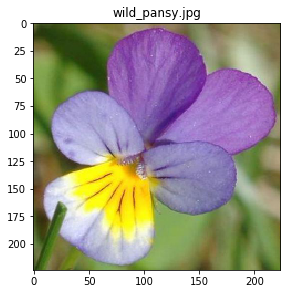

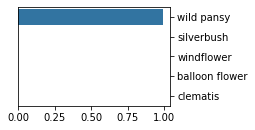

In [47]:
# image 3
plt.figure(figsize = (10,10))
plot_image(image3_path,0)
plt.show()

(224, 224, 3) (1, 224, 224, 3)
prediction probabilities :
 [0.3966372013092041, 0.19429881870746613, 0.08536359667778015, 0.07862532138824463, 0.039992958307266235] 

prediction classes:
 [58, 4, 65, 99, 70] 

prediction labels:
 ['orange dahlia', 'english marigold', 'osteospermum', 'blanket flower', 'gazania'] 



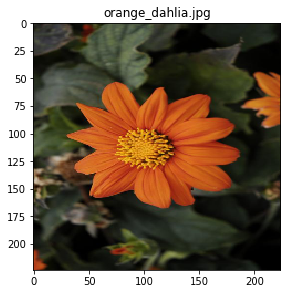

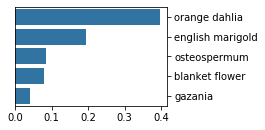

In [48]:
# image 4
plt.figure(figsize = (10,10))
plot_image(image4_path,1)
plt.show()